In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [2]:
import cv2
import pandas as pd
import pydicom
from fastai.vision import *
from fastai.callbacks import *
from fastai.data_block import _maybe_squeeze
from collections import defaultdict

In [3]:
import torch
torch.cuda.device(0)

In [4]:
torch.cuda.get_device_name()

'GeForce GTX 1070'

In [5]:
path = Path('/mnt/fst/shaan/rsna-intracranial-hemorrhage-detection')
cmap='jet'

In [6]:
import os
files = os.listdir("/mnt/fst/shaan/rsna-intracranial-hemorrhage-detection/train224")
test_files = os.listdir("/mnt/fst/shaan/rsna-intracranial-hemorrhage-detection/test224")

In [7]:
df = pd.read_csv(path/'stage_1_train.csv')
df['fn'] = df.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.dcm')
df.columns = ['ID', 'probability', 'fn']
df['label'] = df.ID.apply(lambda x: x.split('_')[-1])
df.drop_duplicates('ID', inplace=True)
pivot = df.pivot(index='fn', columns='label', values='probability')
pivot.reset_index(inplace=True)
d = defaultdict(list)
for fn in df.fn.unique(): 
    d[fn]
for tup in df.itertuples():
    if tup.probability: 
        d[tup.fn].append(tup.label)
        
ks, vs = [], []

for k, v in d.items():
    ks.append(k), vs.append(' '.join(v))
    
df_train = pd.DataFrame(data={'fn': ks, 'labels': vs})
df_train.labels.fillna('', inplace=True)
df_train = df_train[df_train['fn'] != 'ID_6431af929.dcm']
df_train.reset_index(drop=True, inplace=True)

In [8]:
df_trn = pd.read_feather(path/'df_trn.fth')
df_trn = df_trn[df_trn['SOPInstanceUID'] != 'ID_6431af929']
df_trn

,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,...,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1
0,ID_231d901c1,CT,ID_b81a287f,ID_dd37ba3adb,ID_15dcd6057a,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-1024,3263,171.462490,828.102464,0.164074,NaN,NaN,NaN,NaN
1,ID_994bc0470,CT,ID_400facde,ID_c5277f0c63,ID_4ba12c2161,,-125.0,1.0,1,MONOCHROME2,...,0.488281,0,2507,430.418091,599.742963,0.198139,1.0,47.0,1.0,80.0
2,ID_127689cce,CT,ID_42910d3d,ID_db93ade25b,ID_c4b4931314,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-2000,2810,12.801376,1209.046168,0.250923,NaN,NaN,NaN,NaN
3,ID_25457734a,CT,ID_329aafa7,ID_8dd6d32f3b,ID_116558f409,,-114.0,1.0,1,MONOCHROME2,...,0.445312,0,2647,566.557011,610.152845,0.298386,1.0,36.0,1.0,80.0
4,ID_81c9aa125,CT,ID_6b544c3c,ID_2685c5d5c0,ID_f56d7bd0f9,,-115.0,1.0,1,MONOCHROME2,...,0.449219,4,1570,178.512295,358.235071,0.006176,1.0,36.0,1.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674253,ID_1b415e1cc,CT,ID_b13dd1c5,ID_a56ee65b9f,ID_70961fe25e,,-156.0,1.0,1,MONOCHROME2,...,0.609375,4,2612,292.513027,469.929874,0.100445,1.0,36.0,1.0,80.0
674254,ID_59ec44ad3,CT,ID_683fd24c,ID_405c292102,ID_9c1e421cad,,-120.5,1.0,1,MONOCHROME2,...,0.470703,3,2452,559.591610,578.345477,0.171585,1.0,36.0,1.0,80.0
674255,ID_c6516b047,CT,ID_75f878eb,ID_64406ff4f4,ID_87fe0fa9f4,,-109.5,1.0,1,MONOCHROME2,...,0.427734,9,2646,524.992954,567.491898,0.172607,1.0,36.0,1.0,80.0
674256,ID_2c0ac4759,CT,ID_cf94e855,ID_a8aff1a18e,ID_fa5855e749,,-106.5,1.0,1,MONOCHROME2,...,0.416016,0,4000,544.195152,573.152837,0.209194,1.0,36.0,1.0,80.0


In [9]:
bad_img = list(df_trn[df_trn.img_pct_window<0.025].SOPInstanceUID)
bad_img = [s + '.dcm' for s in bad_img]
bad_img

['ID_81c9aa125.dcm',
 'ID_a31462f2a.dcm',
 'ID_0acb28b87.dcm',
 'ID_7ad9ec79d.dcm',
 'ID_1029cc830.dcm',
 'ID_78f04b7d1.dcm',
 'ID_7a0d8a53f.dcm',
 'ID_ea2568d47.dcm',
 'ID_c0c3c5e80.dcm',
 'ID_2f124f224.dcm',
 'ID_6e922e6c0.dcm',
 'ID_9db1dd7fb.dcm',
 'ID_e425db695.dcm',
 'ID_73d43e137.dcm',
 'ID_4777fd31b.dcm',
 'ID_6327b8d38.dcm',
 'ID_aa241029b.dcm',
 'ID_eb6ab0790.dcm',
 'ID_b16095ca8.dcm',
 'ID_3a626bb70.dcm',
 'ID_cf4cb07e2.dcm',
 'ID_ba098b526.dcm',
 'ID_b58fe3c5b.dcm',
 'ID_88d25c1bc.dcm',
 'ID_6939a1303.dcm',
 'ID_d7cc266e5.dcm',
 'ID_38e4700ea.dcm',
 'ID_17a077f2e.dcm',
 'ID_000ada5fc.dcm',
 'ID_c4a1a689d.dcm',
 'ID_8e704bc00.dcm',
 'ID_fad0346b8.dcm',
 'ID_d52765ca8.dcm',
 'ID_0135a2814.dcm',
 'ID_39065f5de.dcm',
 'ID_07d914f5f.dcm',
 'ID_99fbcbf35.dcm',
 'ID_c3f736a1e.dcm',
 'ID_76e3b4e0f.dcm',
 'ID_85372445f.dcm',
 'ID_3b2232047.dcm',
 'ID_740be9098.dcm',
 'ID_3f2848a01.dcm',
 'ID_14bb5b755.dcm',
 'ID_d12e704a8.dcm',
 'ID_b2890a394.dcm',
 'ID_d37088a1f.dcm',
 'ID_12ec0813

In [10]:
df_trn = df_trn[~(df_trn.img_pct_window<0.025)]
a = df_trn.PatientID.value_counts().reset_index()
a.columns = ['PatientID', 'num']
val_ID = a.PatientID[4::5].tolist()
val_img = df_trn[df_trn.PatientID.isin(val_ID)].SOPInstanceUID.tolist()
val_img = [s + '.dcm' for s in val_img]

In [11]:
df_train = df_train[~(df_train.fn.isin(bad_img))]
df_train.loc[~(df_train.fn.isin(val_img)), 'is_valid'] = False
df_train.loc[df_train.fn.isin(val_img), 'is_valid'] = True
# df_train = df_train[:50000].copy()
df_train.reset_index(drop=True, inplace=True)
df_train

,fn,labels,is_valid
0,ID_63eb1e259.dcm,,False
1,ID_2669954a7.dcm,,False
2,ID_52c9913b1.dcm,,False
3,ID_4e6ff6126.dcm,,False
4,ID_7858edd88.dcm,,False
...,...,...,...
591938,ID_6a6cd0773.dcm,,False
591939,ID_f737f4cc1.dcm,,True
591940,ID_a9797cb3a.dcm,,False
591941,ID_9375f67bd.dcm,,False


In [12]:
sub1 = pd.read_csv(path/'stage_1_sample_submission.csv')
sub1['fn'] = sub1.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.dcm')
sub1.columns = ['ID', 'probability', 'fn']
sub1['label'] = sub1.ID.apply(lambda x: x.split('_')[-1])
sub1.drop_duplicates('ID', inplace=True)
sub = sub1.pivot(index='fn', columns='label', values='probability')
sub.reset_index(inplace=True)
sub

label,fn,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf.dcm,0.5,0.5,0.5,0.5,0.5,0.5
1,ID_0000ca2f6.dcm,0.5,0.5,0.5,0.5,0.5,0.5
2,ID_000259ccf.dcm,0.5,0.5,0.5,0.5,0.5,0.5
3,ID_0002d438a.dcm,0.5,0.5,0.5,0.5,0.5,0.5
4,ID_00032d440.dcm,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
78540,ID_fffe2edb8.dcm,0.5,0.5,0.5,0.5,0.5,0.5
78541,ID_ffff3212e.dcm,0.5,0.5,0.5,0.5,0.5,0.5
78542,ID_ffff59a97.dcm,0.5,0.5,0.5,0.5,0.5,0.5
78543,ID_ffffb670a.dcm,0.5,0.5,0.5,0.5,0.5,0.5


In [13]:
sub.loc[899,:]

label
fn                  ID_030952361.dcm
any                              0.5
epidural                         0.5
intraparenchymal                 0.5
intraventricular                 0.5
subarachnoid                     0.5
subdural                         0.5
Name: 899, dtype: object

In [14]:
class DicomImage(Image):
    "DicomImage to support applying transforms to image data in `px`."
    def __init__(self, px:Tensor):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}
    
    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            plt.imsave(str_buffer, image2np(self.px[0].unsqueeze(0)), # We show only one channel!
                       format=format_str, cmap=cmap)
            return str_buffer.getvalue()
        
    def clone(self):
        "Mimic the behavior of torch.clone for `Image` objects."
        return self.__class__(self.px.clone())

    @property
    def data(self)->TensorImage:
        "Return this images pixels as a tensor."
        return self.px
    
    def show(self, ax:plt.Axes=None, figsize:tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True,
              cmap:str=cmap, y:Any=None, **kwargs):
        "Show image on `ax` with `title`, overlaid with optional `y`"
        ax = show_dicom_image(self, ax=ax, hide_axis=hide_axis, cmap=cmap, figsize=figsize)
        if y is not None: y.show(ax=ax, **kwargs)
        if title is not None: ax.set_title(title)

In [15]:
def open_dicom_image(fn:PathOrStr, cls:type=DicomImage, 
                     after_open:Callable=None, expand=True,
                     clamp_min=-1024, clamp_max=1024)->Image:
    "Return `Image` object created from image in file `fn`."
    
    def correct_dcm(dcm):
        x = dcm.pixel_array + 1000
        px_mode = 4096
        x[x>=px_mode] = x[x>=px_mode] - px_mode
        dcm.PixelData = x.tobytes()
        dcm.RescaleIntercept = -1000
        
    def window_image(dcm, window_center, window_width):
    
        if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
            correct_dcm(dcm)

        img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)

        return img

    def bsb_window(dcm):
        brain_img = window_image(dcm, 40, 80)
        subdural_img = window_image(dcm, 80, 200)
        soft_img = window_image(dcm, 40, 380)

        brain_img = (brain_img - 0) / 80
        subdural_img = (subdural_img - (-20)) / 200
        soft_img = (soft_img - (-150)) / 380
        bsb_img = np.array([brain_img, subdural_img, soft_img])

        return bsb_img
    
    dcm = pydicom.dcmread(fn) # open dicom image as dicom dataset
    #img = ds.pixel_array # get pixel data as np array
    #if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
    #    correct_dcm(dcm)
    
    
    # Convert to Hounsfield units (HU) and rescale and set intercept.
    # In this setup we only take a look at the values between -1024 and 1024.
    # Values below will be set to -1024, values above to 1024
    #resc_img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    #resc_img[resc_img < -1024] = clamp_min # Clamp to minimum value   
    #resc_img[resc_img > 1024] = clamp_max # Clamp to maximum value
    #resc_img = (resc_img - clamp_min) / (clamp_max - clamp_min) # rescale to range from 0 to 1
    
#     resc_img = bsb_window(dcm)
    resc_img = bsb_window(dcm)
    
    if after_open: resc_img = after_open(resc_img)
    
    #resc_img = torch.from_numpy(resc_img.astype(np.float32, copy=False))
    x = torch.from_numpy(resc_img.astype(np.float32, copy=False))
    #x = resc_img.view(1,*resc_img.shape)
    #x = resc_img.view()
    
    #if expand: x = x.expand(3,*x.shape[-2:])
    # x.shape[-2:] is needed because not everything is of size 512x512!
    # expand is memory efficient: https://stackoverflow.com/questions/44593141/stacking-copies-of-an-array-a-torch-tensor-efficiently
                
    return cls(x)

In [16]:
def show_dicom_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str=cmap,
                alpha:float=None, **kwargs)->plt.Axes:
    "Display `DicomImage` in the notebook."
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img.data.data[0].unsqueeze(0)), # We show only one channel!
              cmap=cmap, alpha=alpha, **kwargs)
    if hide_axis: ax.axis('off')
    return ax

In [17]:
class DicomImageList(ImageList):
    def __init__(self, *args, after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.after_open = after_open
        self.c,self.sizes = 1,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_dicom_image(fn, after_open=self.after_open)
    
    # based on https://github.com/radekosmulski/rsna-intracranial/blob/master/03_train_basic_model.ipynb
    def label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
        "Label `self.items` from the values in `cols` in `self.inner_df`."
        self.inner_df.labels.fillna('', inplace=True)
        labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
        assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
        if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
            new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
            kwargs = {**new_kwargs, **kwargs}
        return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)
    
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()): x.show(ax=ax, y=y, **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()
        
    def reconstruct(self, t): return DicomImage(t)

In [18]:
fn = '/mnt/fst/shaan/rsna-intracranial-hemorrhage-detection/stage_1_test_images/ID_01e84b842.dcm'
fn

'/mnt/fst/shaan/rsna-intracranial-hemorrhage-detection/stage_1_test_images/ID_01e84b842.dcm'

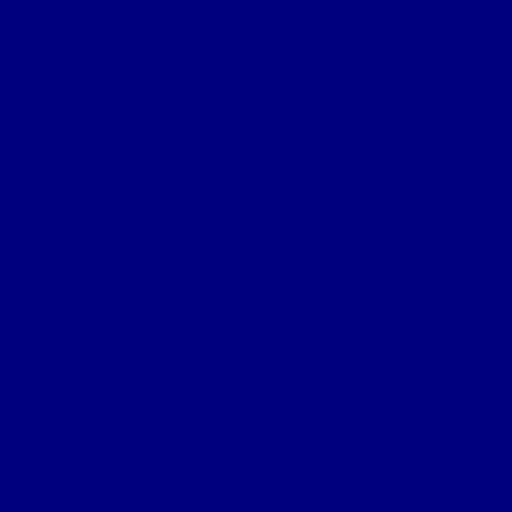

In [19]:
img = open_dicom_image(fn)
img

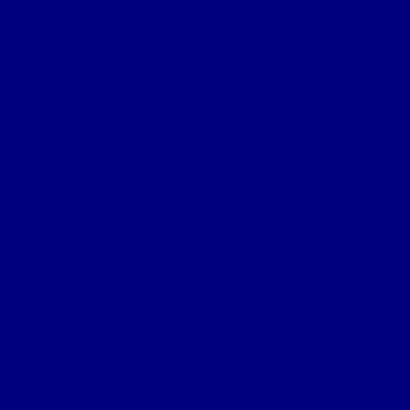

In [20]:
img.resize(410)

In [21]:
tfms = get_transforms(do_flip=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [22]:
np.random.seed(42)
src = (DicomImageList.from_df(df_train, path, folder='stage_1_train_images')
       .split_from_df()
       .label_from_df(cols=-2, label_delim=' '))

In [23]:
data = (src.transform(tfms, size=410)
        .databunch(bs=16).normalize(imagenet_stats))

In [24]:
test = DicomImageList.from_df(sub, path=path, folder='stage_1_test_images')
test

DicomImageList (78545 items)
DicomImage (3, 512, 512),DicomImage (3, 512, 512),DicomImage (3, 512, 512),DicomImage (3, 512, 512),DicomImage (3, 512, 512)
Path: /mnt/fst/shaan/rsna-intracranial-hemorrhage-detection

In [25]:
data.add_test(test)

In [26]:
data

ImageDataBunch;

Train: LabelList (473732 items)
x: DicomImageList
DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410)
y: MultiCategoryList
,,,,
Path: /mnt/fst/shaan/rsna-intracranial-hemorrhage-detection;

Valid: LabelList (118211 items)
x: DicomImageList
DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410)
y: MultiCategoryList
,,,,
Path: /mnt/fst/shaan/rsna-intracranial-hemorrhage-detection;

Test: LabelList (78545 items)
x: DicomImageList
DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410)
y: EmptyLabelList
,,,,
Path: /mnt/fst/shaan/rsna-intracranial-hemorrhage-detection

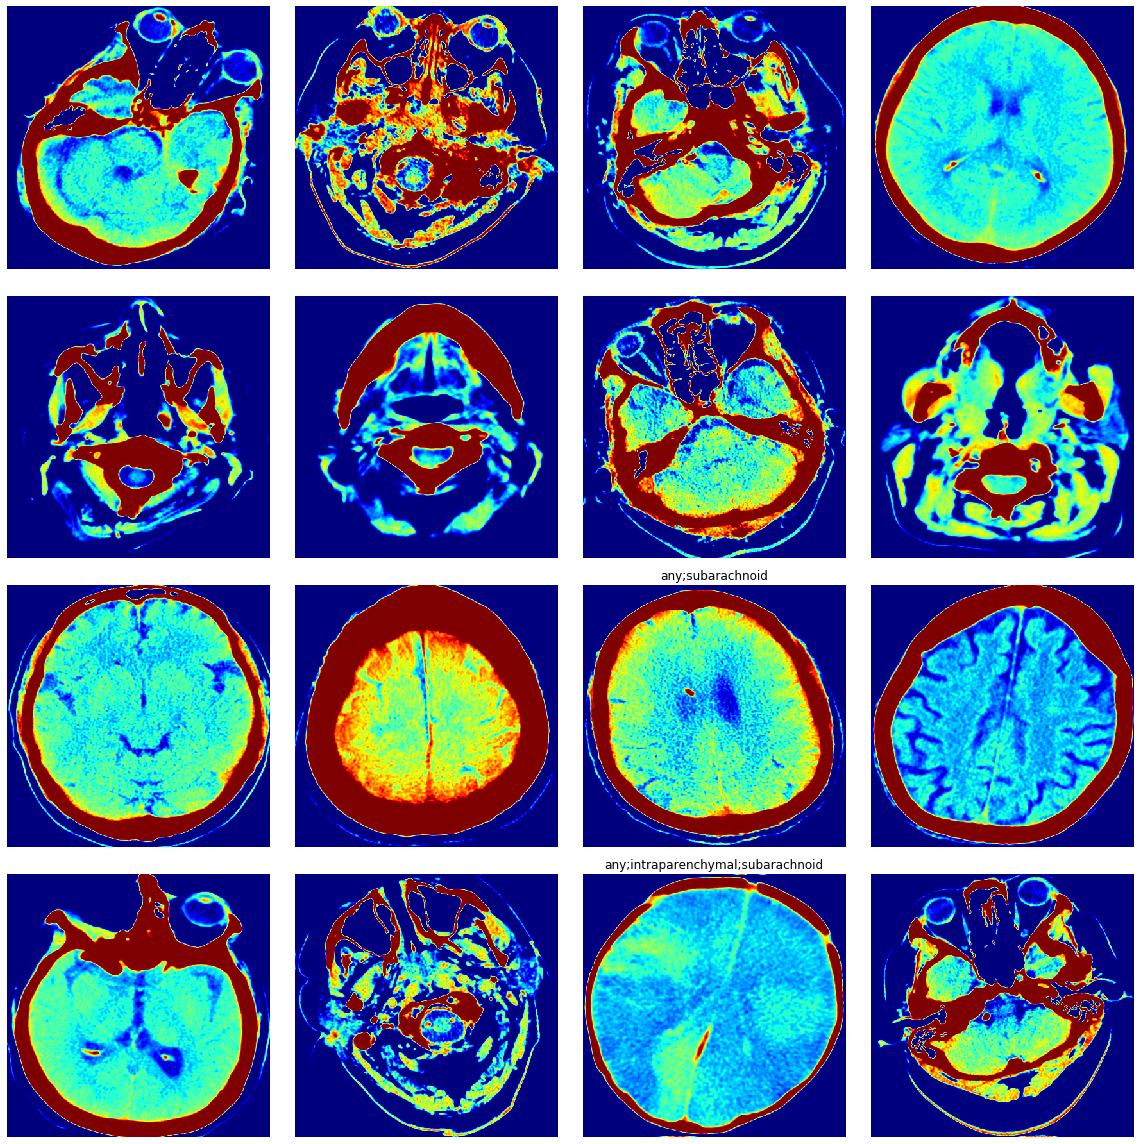

In [27]:
data.show_batch()

In [28]:
from efficientnet_pytorch import EfficientNet

# def get_model(pretrained=True, **kwargs):
#     model = EfficientNet.from_pretrained('efficientnet-b2')
#     model._fc = nn.Linear(model._fc.in_features, data.c)
#     return model
    
model = EfficientNet.from_pretrained('efficientnet-b2', num_classes=data.c)

Loaded pretrained weights for efficientnet-b2


In [28]:
# loss_weights = [2,1,1,1,1,1]
# loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(loss_weights).float().cuda())
# def loss_fn(preds, targ): 
#     return loss(preds, targ.float())

In [30]:
learn = Learner(data, model, loss_func=torch.nn.BCEWithLogitsLoss(), metrics=fbeta)
# learn = learn.split([learn.model._conv_stem,learn.model._blocks,learn.model._conv_head])
# learn.freeze()

In [30]:
learn.summary()

EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 411, 411]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 205, 205]       64         True      
______________________________________________________________________
ZeroPad2d            [32, 207, 207]       0          False     
______________________________________________________________________
BatchNorm2d          [32, 205, 205]       64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 205, 205]       0          False     
_________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02
Min loss divided by 10: 1.00E-02


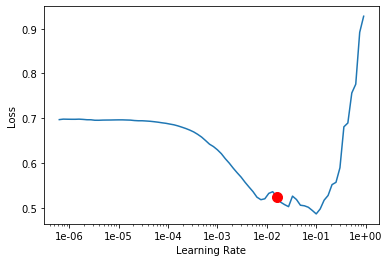

In [31]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [32]:
lr = 1e-2
learn.fit_one_cycle(5, lr, 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='dicom_best_410_validgrouped_image_preprocessed')])

epoch,train_loss,valid_loss,fbeta,time
0,0.109107,0.190108,0.055390,5:53:02
1,0.132308,0.129901,0.094004,5:53:20
2,0.103372,0.120015,0.102325,5:53:16
3,0.087122,0.109664,0.104374,5:53:38
4,0.076821,0.079110,0.132570,5:53:29


Better model found at epoch 0 with valid_loss value: 0.19010765850543976.
Better model found at epoch 1 with valid_loss value: 0.12990136444568634.
Better model found at epoch 2 with valid_loss value: 0.12001482397317886.
Better model found at epoch 3 with valid_loss value: 0.1096644327044487.
Better model found at epoch 4 with valid_loss value: 0.07910973578691483.


In [33]:
learn.save('rsna-dicom-effb2-410-validgrouped-image-preprocessed-stage1')

In [31]:
learn.load('dicom_best_410_validgrouped_image_preprocessed')

Learner(data=ImageDataBunch;

Train: LabelList (473732 items)
x: DicomImageList
DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410)
y: MultiCategoryList
,,,,
Path: /mnt/fst/shaan/rsna-intracranial-hemorrhage-detection;

Valid: LabelList (118211 items)
x: DicomImageList
DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410)
y: MultiCategoryList
,,,,
Path: /mnt/fst/shaan/rsna-intracranial-hemorrhage-detection;

Test: LabelList (78545 items)
x: DicomImageList
DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410),DicomImage (3, 410, 410)
y: EmptyLabelList
,,,,
Path: /mnt/fst/shaan/rsna-intracranial-hemorrhage-detection, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )


In [33]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [34]:
preds

tensor([[5.9050e-02, 1.2717e-03, 9.0828e-03, 1.1335e-02, 9.4912e-03, 2.9021e-02],
        [1.8709e-03, 1.5708e-05, 7.0591e-04, 4.5888e-05, 8.6541e-04, 1.1976e-03],
        [7.3532e-09, 2.6566e-10, 6.2123e-09, 1.6175e-11, 6.8544e-09, 5.2241e-09],
        ...,
        [3.0500e-11, 6.2802e-14, 1.4618e-11, 6.7564e-13, 4.1322e-11, 3.6194e-10],
        [2.3542e-02, 8.3568e-04, 4.1306e-03, 3.3233e-03, 1.1736e-02, 6.4429e-03],
        [2.5452e-03, 1.2306e-04, 3.6806e-04, 1.9618e-04, 7.7781e-04, 2.1843e-03]])

In [35]:
datasetIndex = []
num = len(learn.data.test_ds)

for i in range(num):
    datasetIndex.append(str(learn.data.test_ds.items[i]).split('/')[-1])

In [36]:
datasetIndex

['ID_000012eaf.dcm',
 'ID_0000ca2f6.dcm',
 'ID_000259ccf.dcm',
 'ID_0002d438a.dcm',
 'ID_00032d440.dcm',
 'ID_00044a417.dcm',
 'ID_0004cd66f.dcm',
 'ID_0005b2d86.dcm',
 'ID_0005db660.dcm',
 'ID_000624786.dcm',
 'ID_0006441d0.dcm',
 'ID_00067e05e.dcm',
 'ID_000716c43.dcm',
 'ID_0007c5cb8.dcm',
 'ID_00086a66f.dcm',
 'ID_0008f134d.dcm',
 'ID_000920cd1.dcm',
 'ID_0009c4591.dcm',
 'ID_000b8242c.dcm',
 'ID_000dcad55.dcm',
 'ID_000dfc63c.dcm',
 'ID_000e918cb.dcm',
 'ID_000edbf38.dcm',
 'ID_000ef9a73.dcm',
 'ID_000f4b376.dcm',
 'ID_000ff2f62.dcm',
 'ID_0010c2cba.dcm',
 'ID_001397ee7.dcm',
 'ID_0013ac1b1.dcm',
 'ID_001423669.dcm',
 'ID_0014fa8d6.dcm',
 'ID_0015ed96c.dcm',
 'ID_00168a161.dcm',
 'ID_0016fa1ac.dcm',
 'ID_0017dbe86.dcm',
 'ID_0017f3209.dcm',
 'ID_00180d0bf.dcm',
 'ID_0018abbe1.dcm',
 'ID_001af9a11.dcm',
 'ID_001b5d5db.dcm',
 'ID_001c4f769.dcm',
 'ID_001c66334.dcm',
 'ID_001c828ec.dcm',
 'ID_001d0012a.dcm',
 'ID_001f46a1c.dcm',
 'ID_00216d818.dcm',
 'ID_002185add.dcm',
 'ID_002287eb

In [37]:
classes = (pivot.columns.tolist()[1:])
classes

['any',
 'epidural',
 'intraparenchymal',
 'intraventricular',
 'subarachnoid',
 'subdural']

In [38]:
ids = []
labels = []

for path, pred in zip(sorted(test_files), preds):
    for i, label in enumerate(classes):
        ids.append(f"{path.split('.')[0]}_{label}")
        predicted_probability = '{0:1.10f}'.format(pred[i].item())
        labels.append(predicted_probability)

In [39]:
sub_df = pd.DataFrame({'ID': ids, 'Label': labels})
sub_df

,ID,Label
0,ID_000012eaf_any,0.0590496883
1,ID_000012eaf_epidural,0.0012716588
2,ID_000012eaf_intraparenchymal,0.0090828352
3,ID_000012eaf_intraventricular,0.0113351410
4,ID_000012eaf_subarachnoid,0.0094912304
...,...,...
471265,ID_ffffcbff8_epidural,0.0001230605
471266,ID_ffffcbff8_intraparenchymal,0.0003680557
471267,ID_ffffcbff8_intraventricular,0.0001961838
471268,ID_ffffcbff8_subarachnoid,0.0007778084


In [40]:
sub_df.to_csv('fastai-effb2-410-3channel-dicom-0.025delete-validgrouped-image-preprocessed.csv', index=False)

In [ ]:
preds_tta, _ = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
preds_tta

In [ ]:
ids = []
labels_tta = []

for path, pred in zip(sorted(test_files), preds_tta):
    for i, label in enumerate(classes):
        ids.append(f"{path.split('.')[0]}_{label}")
        predicted_probability = '{0:1.10f}'.format(pred[i].item())
        labels_tta.append(predicted_probability)

In [ ]:
sub_df_tta = pd.DataFrame({'ID': ids, 'Label': labels_tta})
sub_df_tta

In [ ]:
sub_df_tta.to_csv('fastai-effb2-410-3channel-dicom-0.025delete-validgrouped-tta-stage1.csv', index=False)

In [ ]:
# png = os.listdir('/mnt/fst/shaan/rsna-intracranial-hemorrhage-detection/png-rashid')
# png

In [ ]:
# import matplotlib.image as mpimg
# img = mpimg.imread('/mnt/fst/shaan/rsna-intracranial-hemorrhage-detection/png-rashid/'+png[0])
# plt.imshow(img, cmap=cmap)